# pvlib-Python Forecasting (Albuquerque, NM)
### Install Standard Release 

In [1]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (20.1.1)


In [2]:
# Package from the Python Package Index
!pip install pvlib

# Module netCDF4 was not found 
!pip install netCDF4

# Module siphon was not found
!pip install siphon

# 4/20/2020: version 1.1.2 released. Code optimization, fix logic so only_use_cftime_datimes=False works as expected (issues #158 and #165). 
!pip install cftime==1.1.2


# Try to save Excel
!pip install openpyxl

  Using cached pvlib-0.7.2-py3-none-any.whl (20.4 MB)
     |████████████████████████████████| 4.1 MB 2.3 MB/s eta 0:00:01     |██████████████████▎             | 2.3 MB 2.3 MB/s eta 0:00:01     |██████████████████████████████▍ | 3.9 MB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 322 kB 12.5 MB/s eta 0:00:01
     |████████████████████████████████| 66 kB 204 kB/s eta 0:00:01
     |████████████████████████████████| 320 kB 2.4 MB/s eta 0:00:01
  Attempting uninstall: cftime
    Found existing installation: cftime 1.1.3
    Uninstalling cftime-1.1.3:
      Successfully uninstalled cftime-1.1.3


In [20]:
# Make basic imports and then set the location and time range data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytz
import seaborn as sns; sns.set_color_codes()
import datetime

# Import pvlib forecast models
from pvlib.forecast import GFS, NAM, NDFD, HRRR, RAP
from pvlib import solarposition
from pvlib.location import Location
from matplotlib.pyplot import figure
%matplotlib inline

# Specify Location (Albuiquerque, NM)
latitude, longitude, tz = 35, -106.6, 'US/Mountain'

# Specify time range
start = pd.Timestamp(datetime.date.fromordinal(737563), tz=tz)
end = start + pd.Timedelta(days=7)
irrad_vars = ['ghi','dni','dhi']

In [21]:
pytz.all_timezones

['Africa/Abidjan',
 'Africa/Accra',
 'Africa/Addis_Ababa',
 'Africa/Algiers',
 'Africa/Asmara',
 'Africa/Asmera',
 'Africa/Bamako',
 'Africa/Bangui',
 'Africa/Banjul',
 'Africa/Bissau',
 'Africa/Blantyre',
 'Africa/Brazzaville',
 'Africa/Bujumbura',
 'Africa/Cairo',
 'Africa/Casablanca',
 'Africa/Ceuta',
 'Africa/Conakry',
 'Africa/Dakar',
 'Africa/Dar_es_Salaam',
 'Africa/Djibouti',
 'Africa/Douala',
 'Africa/El_Aaiun',
 'Africa/Freetown',
 'Africa/Gaborone',
 'Africa/Harare',
 'Africa/Johannesburg',
 'Africa/Juba',
 'Africa/Kampala',
 'Africa/Khartoum',
 'Africa/Kigali',
 'Africa/Kinshasa',
 'Africa/Lagos',
 'Africa/Libreville',
 'Africa/Lome',
 'Africa/Luanda',
 'Africa/Lubumbashi',
 'Africa/Lusaka',
 'Africa/Malabo',
 'Africa/Maputo',
 'Africa/Maseru',
 'Africa/Mbabane',
 'Africa/Mogadishu',
 'Africa/Monrovia',
 'Africa/Nairobi',
 'Africa/Ndjamena',
 'Africa/Niamey',
 'Africa/Nouakchott',
 'Africa/Ouagadougou',
 'Africa/Porto-Novo',
 'Africa/Sao_Tome',
 'Africa/Timbuktu',
 'Africa/

In [22]:
pytz.country_timezones('US')

['America/New_York',
 'America/Detroit',
 'America/Kentucky/Louisville',
 'America/Kentucky/Monticello',
 'America/Indiana/Indianapolis',
 'America/Indiana/Vincennes',
 'America/Indiana/Winamac',
 'America/Indiana/Marengo',
 'America/Indiana/Petersburg',
 'America/Indiana/Vevay',
 'America/Chicago',
 'America/Indiana/Tell_City',
 'America/Indiana/Knox',
 'America/Menominee',
 'America/North_Dakota/Center',
 'America/North_Dakota/New_Salem',
 'America/North_Dakota/Beulah',
 'America/Denver',
 'America/Boise',
 'America/Phoenix',
 'America/Los_Angeles',
 'America/Anchorage',
 'America/Juneau',
 'America/Sitka',
 'America/Metlakatla',
 'America/Yakutat',
 'America/Nome',
 'America/Adak',
 'Pacific/Honolulu']

In [24]:
# GFS model, defaults to 0.5 degree resolution
# 0.25 deg available 
model = GFS() 

# Retrive data.returns panda.DataFrame object
raw_data = model.get_data(latitude, longitude, start, end)
print(raw_data.head())

                           Wind_speed_gust_surface  \
2020-05-18 06:00:00-06:00                 1.701147   
2020-05-18 09:00:00-06:00                 4.014727   
2020-05-18 12:00:00-06:00                 1.625211   
2020-05-18 15:00:00-06:00                 1.527756   
2020-05-18 18:00:00-06:00                 7.726322   

                           Total_cloud_cover_boundary_layer_cloud_Mixed_intervals_Average  \
2020-05-18 06:00:00-06:00                                                0.0                
2020-05-18 09:00:00-06:00                                                0.0                
2020-05-18 12:00:00-06:00                                                0.0                
2020-05-18 15:00:00-06:00                                                0.0                
2020-05-18 18:00:00-06:00                                                0.0                

                           Temperature_surface  \
2020-05-18 06:00:00-06:00           287.700012   
2020-05-18 09:00

### Process Data with pvlib

In [25]:
# Process this data before using it with pvlib
data = raw_data

# Rename the columns according the key/value pairs in model.variables.
data = model.rename(data)

# Convert temperature
data['temp_air'] = model.kelvin_to_celsius(data['temp_air'])

# Convert wind components to wind speed
data['wind_speed'] = model.uv_to_speed(data)

# Calculate irradiance estimates from cloud cover.
irrad_data = model.cloud_cover_to_irradiance(data['total_clouds'])
data = data.join(irrad_data, how='outer')

# Keep only the final data
data = data[model.output_variables]

print(data.head())

                            temp_air  wind_speed         ghi         dni  \
2020-05-18 06:00:00-06:00  14.550018    1.158899    0.000000    0.000000   
2020-05-18 09:00:00-06:00  13.258087    2.818339  431.380327  372.342906   
2020-05-18 12:00:00-06:00  10.267181    1.257288  853.717445  509.080697   
2020-05-18 15:00:00-06:00  30.092499    1.532309  859.566904  752.596589   
2020-05-18 18:00:00-06:00  41.007965    5.606968  336.044866  612.520753   

                                  dhi  total_clouds  low_clouds  mid_clouds  \
2020-05-18 06:00:00-06:00    0.000000          81.0         0.0        23.0   
2020-05-18 09:00:00-06:00  218.838467          27.0         0.0         0.0   
2020-05-18 12:00:00-06:00  377.202191          14.0         0.0         0.0   
2020-05-18 15:00:00-06:00  207.443727           0.0         0.0         0.0   
2020-05-18 18:00:00-06:00   89.048641           0.0         0.0         0.0   

                           high_clouds  
2020-05-18 06:00:00-06:00  

### GFS'S Class

In [26]:
# process_data method combines these steps in a single function
data = model.process_data(raw_data)
print(data.head())

# Implement their own process_data methods on inherited classes or implement similar stand-alone functions
# Also implement a get_processed_data() method that combines the get_data() and process_data() calls
data = model.get_processed_data(latitude, longitude, start, end)
print(data.head())

                            temp_air  wind_speed         ghi         dni  \
2020-05-18 06:00:00-06:00  14.550018    1.158899    0.000000    0.000000   
2020-05-18 09:00:00-06:00  13.258087    2.818339  431.380327  372.342906   
2020-05-18 12:00:00-06:00  10.267181    1.257288  853.717445  509.080697   
2020-05-18 15:00:00-06:00  30.092499    1.532309  859.566904  752.596589   
2020-05-18 18:00:00-06:00  41.007965    5.606968  336.044866  612.520753   

                                  dhi  total_clouds  low_clouds  mid_clouds  \
2020-05-18 06:00:00-06:00    0.000000          81.0         0.0        23.0   
2020-05-18 09:00:00-06:00  218.838467          27.0         0.0         0.0   
2020-05-18 12:00:00-06:00  377.202191          14.0         0.0         0.0   
2020-05-18 15:00:00-06:00  207.443727           0.0         0.0         0.0   
2020-05-18 18:00:00-06:00   89.048641           0.0         0.0         0.0   

                           high_clouds  
2020-05-18 06:00:00-06:00  

## Cloud Cover & Radiation

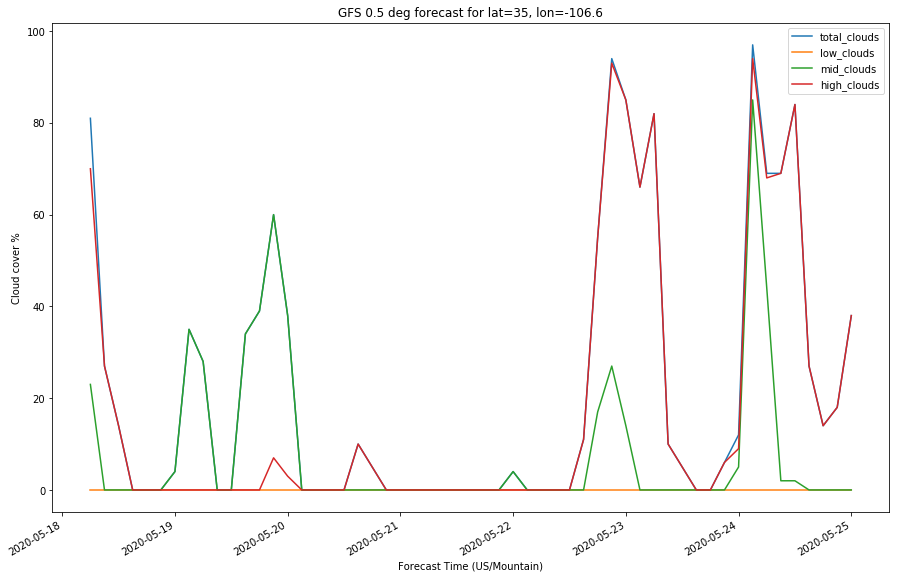

In [27]:
# Plot cloud cover percentages
cloud_vars = ['total_clouds', 'low_clouds','mid_clouds', 'high_clouds']
data[cloud_vars].plot(figsize=(15,10));
plt.ylabel('Cloud cover %');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

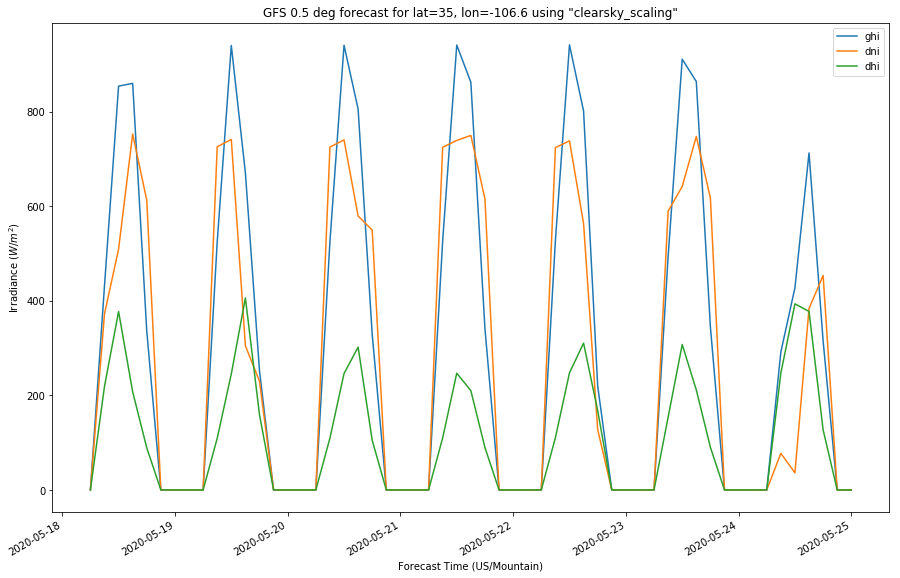

In [28]:
# Plot irradiance data
data = model.rename(raw_data)
irrads = model.cloud_cover_to_irradiance(data['total_clouds'], how='clearsky_scaling')
irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} using "clearsky_scaling"'.format(latitude, longitude));
plt.legend();

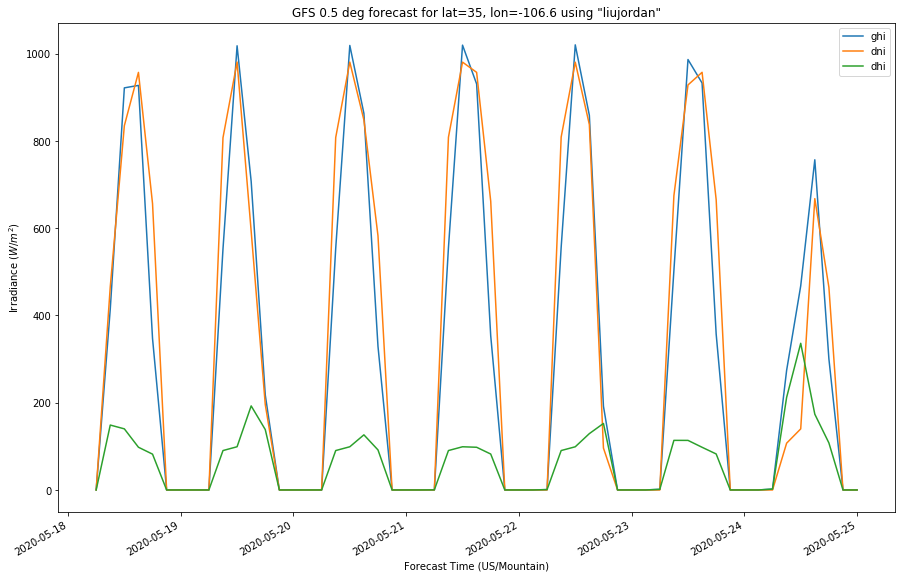

In [29]:
# Plot irradiance data
# Irradiance forecast one hour resolution as the weather data
irrads = model.cloud_cover_to_irradiance(data['total_clouds'], how='liujordan')
irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} using "liujordan"'.format(latitude, longitude));
plt.legend();

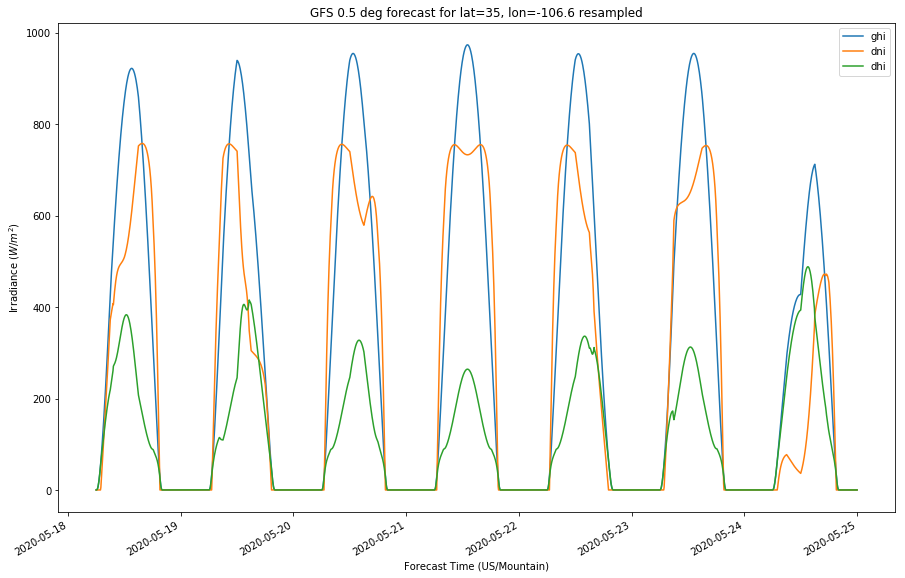

In [30]:
# Five min data resample
resampled_data = data.resample('5min').interpolate()
resampled_irrads = model.cloud_cover_to_irradiance(resampled_data['total_clouds'], how='clearsky_scaling')
resampled_irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} resampled'.format(latitude,longitude));
plt.legend();

## Weather Models
### GFS
- The Global Forecast System is the US model that provides forecast for the entire globe (6hr update)
### HRRR

In [31]:
# High Resolution Rapid Refresh most accurate
# Only available for 15 hours
model = HRRR()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('HRRR 3 km forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

HTTPError: Error accessing https://thredds.ucar.edu/thredds/ncss/grib/NCEP/HRRR/CONUS_2p5km/Best?var=Wind_speed_gust_surface&var=u-component_of_wind_height_above_ground&var=Medium_cloud_cover_middle_cloud&var=Total_cloud_cover_entire_atmosphere&var=Temperature_height_above_ground&var=Low_cloud_cover_low_cloud&var=v-component_of_wind_height_above_ground&var=Pressure_surface&var=High_cloud_cover_high_cloud&time_start=2020-05-18T00%3A00%3A00-06%3A00&time_end=2020-05-25T00%3A00%3A00-06%3A00&longitude=-106.6&latitude=35&accept=netcdf
Server Error (400: Requested time range 2020-05-18T06:00:00Z - 2020-05-25T06:00:00Z does not intersect actual time range 2020-06-01T01:00:00Z - 2020-06-05T11:00:00Z)

### RAP

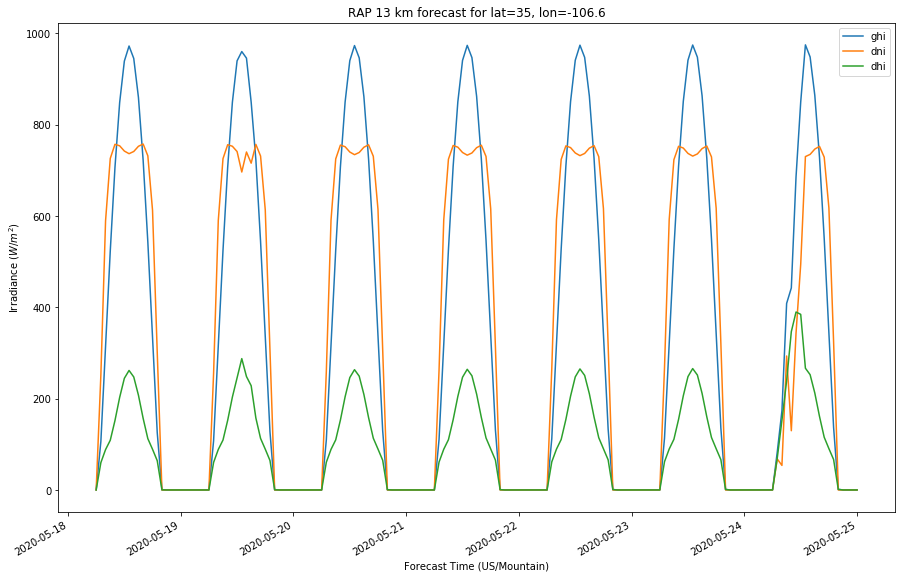

In [38]:
# The Rapid Refresh model is the parent model for the HRRR
# Updated every hour with a 20, 40 km resolution
model = RAP()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('RAP 13 km forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

### NDFD

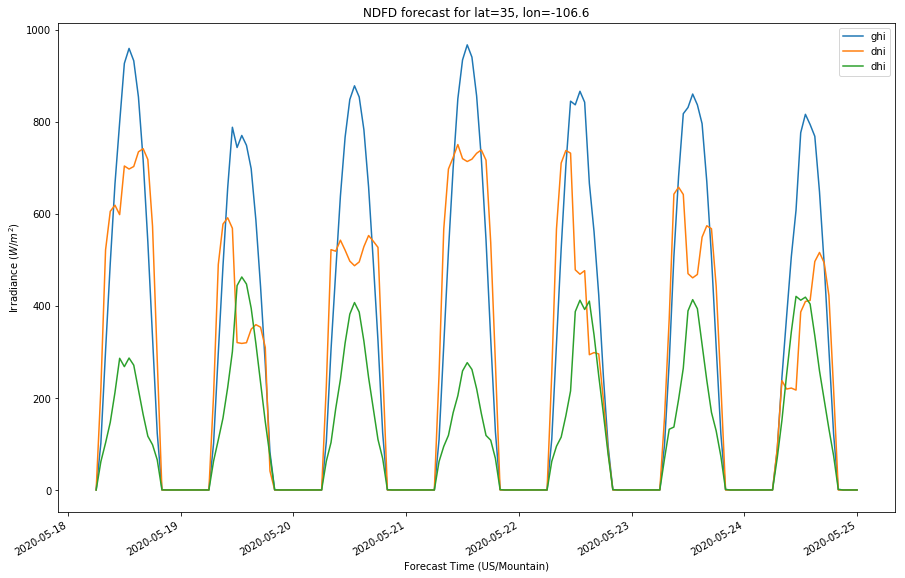

In [42]:
# The National Digital Forecast Database is not a model
# Is a collection of forecasts made by National Weather Service offices accross the country
# Updated every six hours
# Only available for the US
model = NDFD()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('NDFD forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

# PV Power Forecast

In [46]:
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
from pvlib.tracking import SingleAxisTracker
from pvlib.modelchain import ModelChain
from pvlib import pvsystem

sandia_modules = retrieve_sam('sandiamod')
cec_inverters = retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = cec_inverters['iPower__SHO_5_2__240V_']
temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

# model a big tracker for more fun
system = SingleAxisTracker(module_parameters=module, inverter_parameters=inverter, temperature_model_parameters=temperature_model_parameters, modules_per_string=15, strings_per_inverter=1)

# fx is a common abbreviation for forecast
fx_model = GFS()
fx_data = fx_model.get_processed_data(latitude, longitude, start, end)
ac_data = fx_data.resample('5min').interpolate()

# use a ModelChain object to calculate modeling intermediates
mc = ModelChain(system, fx_model.location)

# extract relevant data for model chain
mc.run_model(ac_data)

ModelChain: 
  name: None
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: snlinverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

In [47]:
invdb = pvsystem.retrieve_sam('CECInverter')
invdb

,ABB__MICRO_0_25_I_OUTD_US_208__208V_,ABB__MICRO_0_25_I_OUTD_US_240__240V_,ABB__MICRO_0_3_I_OUTD_US_208__208V_,ABB__MICRO_0_3_I_OUTD_US_240__240V_,ABB__MICRO_0_3HV_I_OUTD_US_208__208V_,ABB__MICRO_0_3HV_I_OUTD_US_240__240V_,ABB__PVI_10_0_I_OUTD_x_US_208_y__208V_,ABB__PVI_10_0_I_OUTD_x_US_480_y_z__480V_,ABB__PVI_12_0_I_OUTD_x_US_480_y__480V_,ABB__PVI_3_0_OUTD_S_US__208V_,...,Zigor__Sunzet_3_TL_US__240V_,i_Energy__GT260__240V_,iPower__SHO_1_1__120V_,iPower__SHO_2_0__240V_,iPower__SHO_2_5__240V_,iPower__SHO_3_0__240V_,iPower__SHO_3_5__240V_,iPower__SHO_4_6__208V_,iPower__SHO_4_8__240V_,iPower__SHO_5_2__240V_
Vac,208,240,208,240,208,240,208,480,480,208,...,240,240,120,240,240,240,240,208,240,240
Pso,2.08961,2.24041,1.84651,1.95054,1.76944,1.84378,46.8638,67.7909,62.5547,18.1663,...,36.0334,2.5301,22.0954,24.4658,42.7765,31.682,64.7742,54.5701,85.1457,62.4867
Paco,250,250,300,300,300,300,10000,10000,12000,3000,...,3180,230,1100,2000,2500,3000,3500,4600,4800,5200
Pdco,259.589,259.492,311.669,311.581,312.421,312.005,10488.3,10296,12358.8,3142.3,...,3315.65,245.63,1194.09,2161.88,2632.84,3205.93,3641.84,4797.81,4968.03,5382.86
Vdco,40,40,40,40,45,45,320,362,370,310,...,375,40,182,199,218,222.5,263,254,263,280
C0,-4.1e-05,-3.9e-05,-3.3e-05,-3.4e-05,-4.5e-05,-3.5e-05,-2.7759e-06,-1.38839e-06,-1.009e-06,-8.03949e-06,...,-7.98467e-06,6.2e-05,-2.1e-05,-1.3e-05,-1.4e-05,-8.21046e-06,-9.08073e-06,-5.99928e-06,-6.16035e-06,-4.63524e-06
C1,-9.1e-05,-0.000132,-0.000192,-0.000256,-0.000196,-0.000227,-3.6e-05,-4.9e-05,-5.6e-05,-1.1e-05,...,-7.5e-05,-9.8e-05,5.7e-05,5.5e-05,6.1e-05,3.6e-05,3.5e-05,2.8e-05,3.4e-05,4.4e-05
C2,0.000494,0.002418,0.000907,0.002453,0.001959,-0.000526,0.000305,-0.00052,-0.001437,0.000999,...,0.000544,0.000231,0.002001,0.001703,0.002053,0.001708,0.001417,0.001381,0.000586,0.00126
C3,-0.013171,-0.014926,-0.031742,-0.028223,-0.023725,-0.041214,-0.002351,-0.003855,-0.007112,-0.000287,...,-0.000338,0.121032,0.000623,0.000315,0.00153,0.00086,0.001218,0.000889,0.000195,0.000367
Pnt,0.075,0.075,0.09,0.09,0.09,0.09,0.1,0.4,0.4,0.1,...,0.954,0.069,0.33,0.6,0.75,0.9,1.05,1.38,1.44,1.56


## ModelChain Attributes

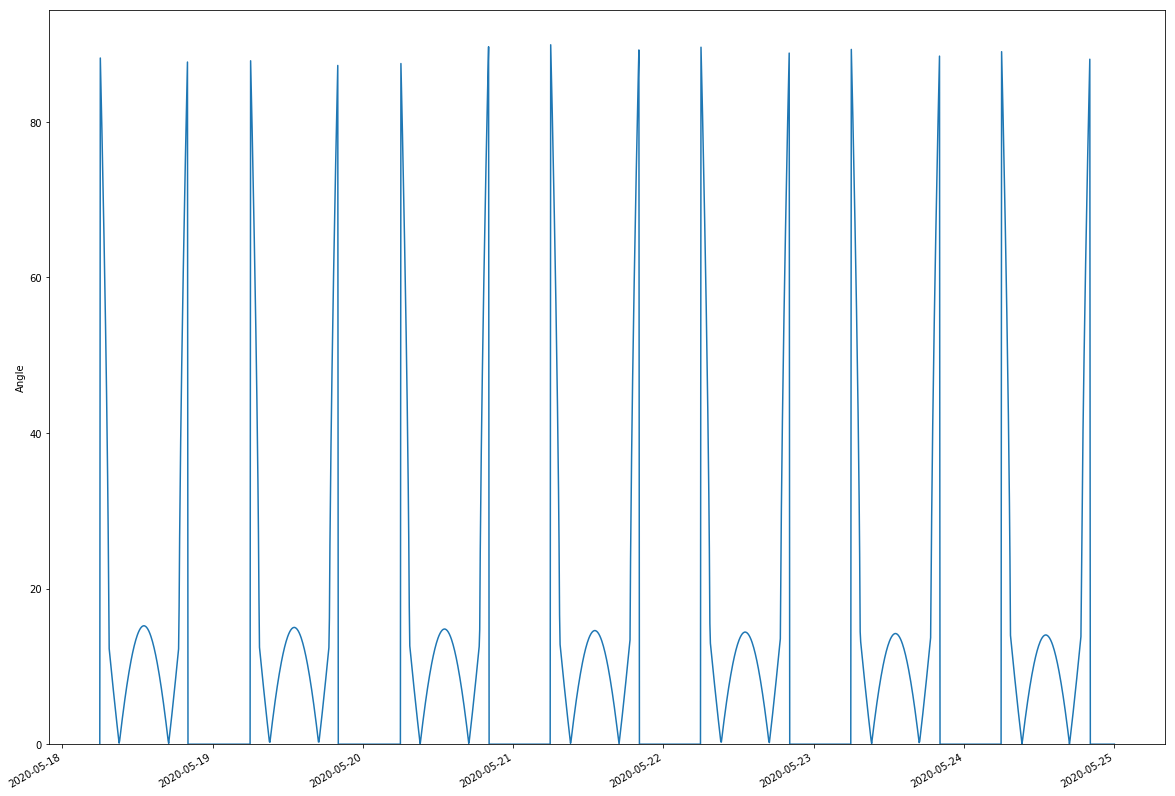

In [48]:
# ModelChain sotres modeling results on a series of attributes. 
# Angle of Incidence
mc.aoi.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('Angle');

## Modeling intermediates & Forecast power

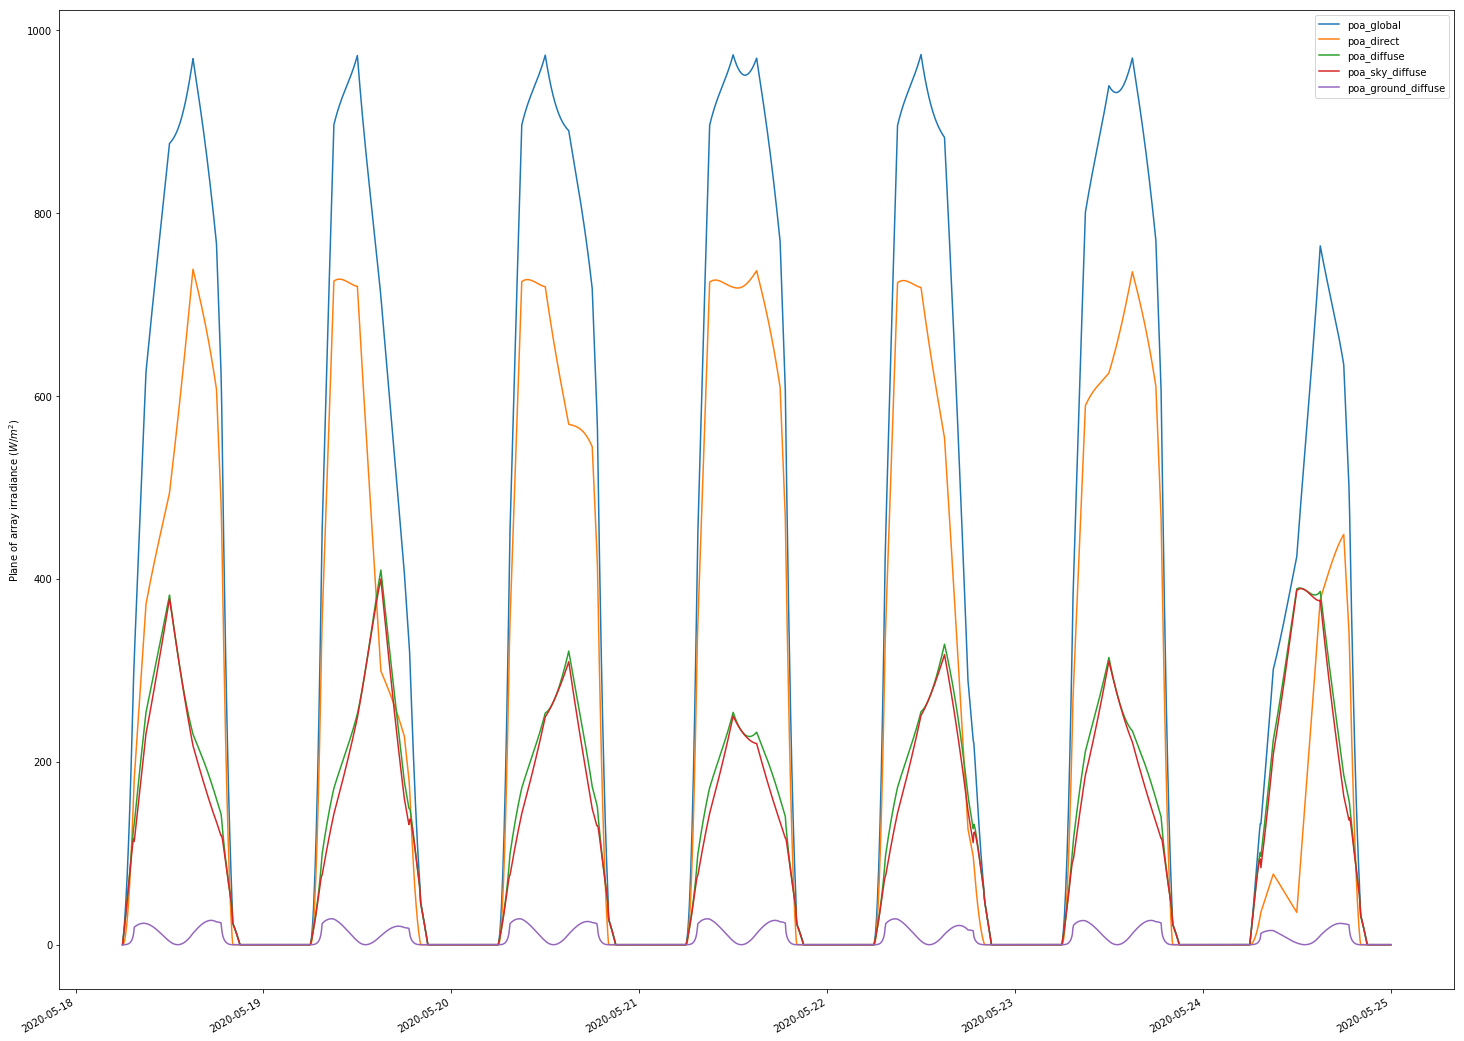

In [57]:
mc.total_irrad.plot(figsize=(25,20));
plt.ylabel('Plane of array irradiance ($W/m^2$)');
plt.legend(loc='best');

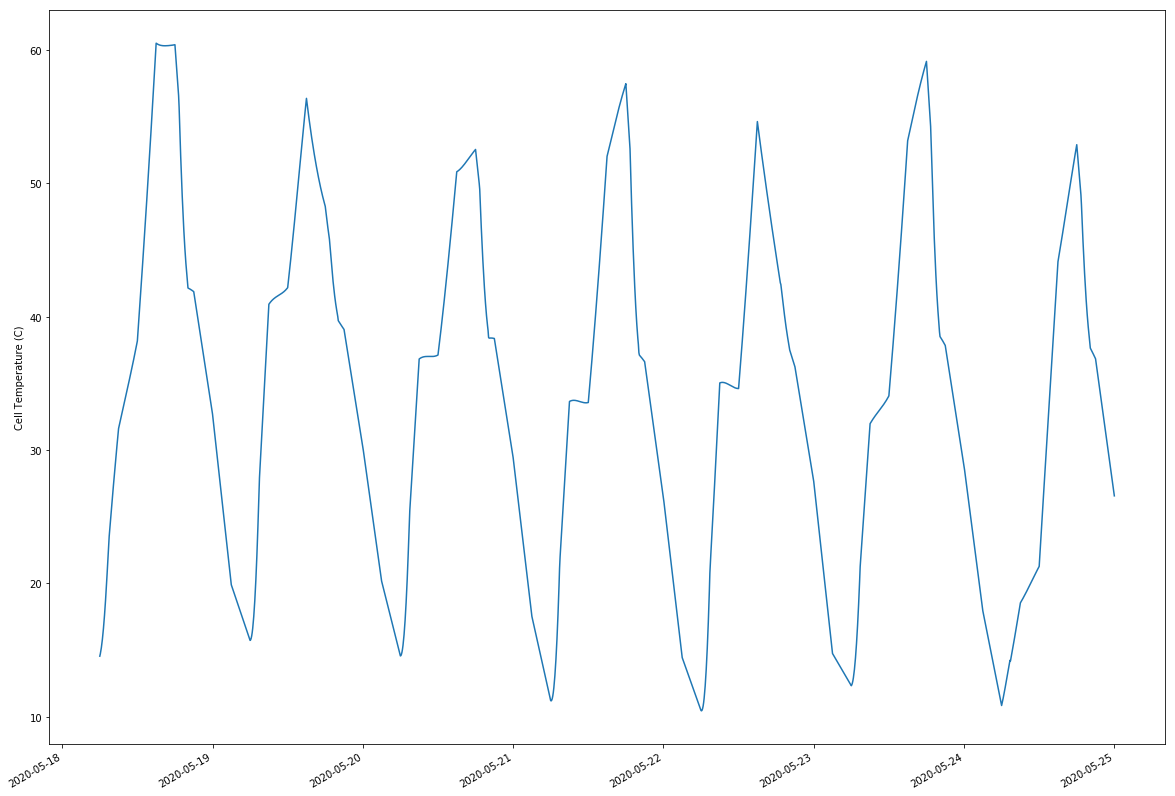

In [58]:
# Cell and module temperature
mc.cell_temperature.plot(figsize=(20,15));
plt.ylabel('Cell Temperature (C)');

## MC DC Power

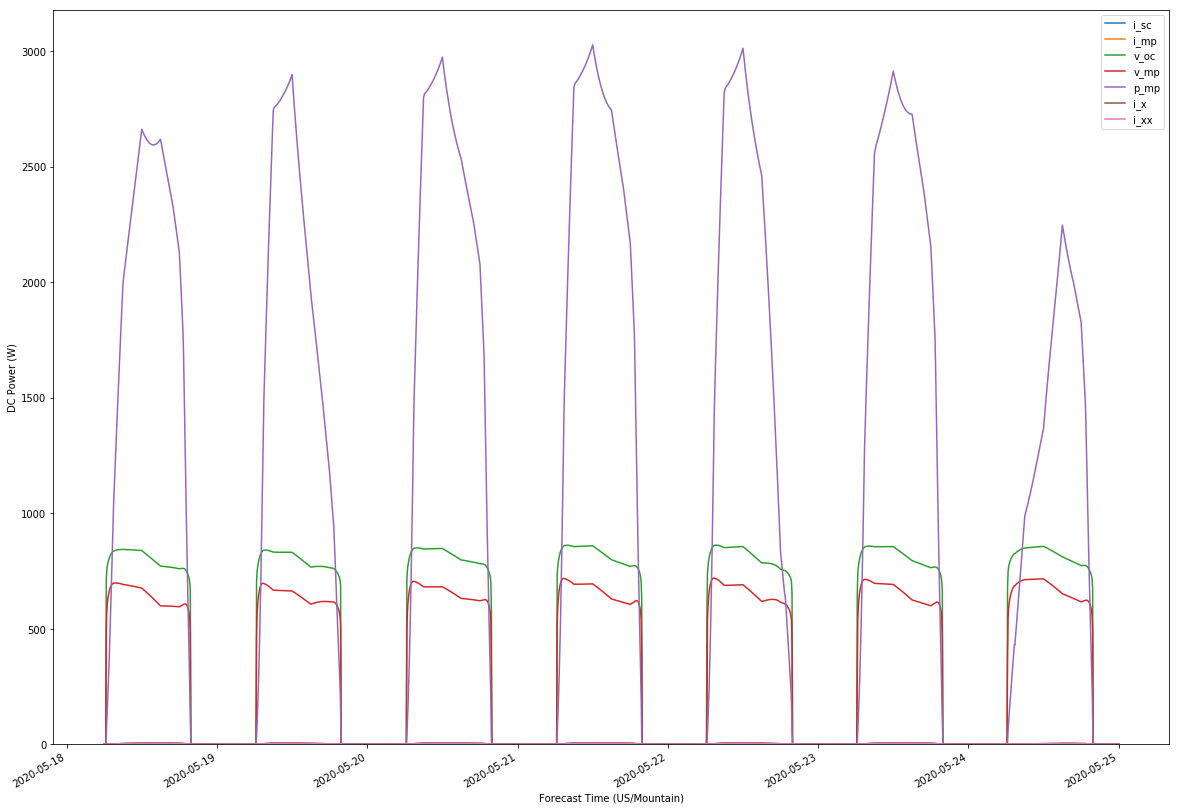

In [59]:
mc.dc.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('DC Power (W)');
plt.xlabel('Forecast Time ({})'.format(tz));

In [60]:
mc.dc.describe()

,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
count,1185.000000,1185.000000,1185.000000,1185.000000,1185.000000,1185.000000,1185.000000
mean,3.281247,2.927254,780.065865,627.026287,1917.827185,3.204544,2.124188
std,1.548657,1.375564,156.659524,131.172928,908.360123,1.513863,0.963861
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.071463,1.856855,772.614027,616.522449,1257.771507,2.020344,1.416521
50%,3.835142,3.416186,813.493410,651.654244,2195.706775,3.744998,2.496820
75%,4.637170,4.133222,845.032901,688.959064,2683.163317,4.530792,2.946785
max,4.931789,4.373182,861.374268,719.429787,3026.915313,4.819467,3.109709


In [61]:
mc.dc.fillna(0)

,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
2020-05-18 06:00:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-05-18 06:05:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-05-18 06:10:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-05-18 06:15:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-05-18 06:20:00-06:00,0.084841,0.076876,714.288814,488.273516,37.536332,0.082632,0.061241
2020-05-18 06:25:00-06:00,0.191057,0.173062,753.786775,574.111397,99.356638,0.186097,0.137524
2020-05-18 06:30:00-06:00,0.278986,0.252633,771.397072,607.536695,153.483587,0.271760,0.200346
2020-05-18 06:35:00-06:00,0.365114,0.330523,783.374070,628.511218,207.737300,0.355678,0.261593
2020-05-18 06:40:00-06:00,0.455589,0.412292,792.828406,643.980293,265.507702,0.443843,0.325626
2020-05-18 06:45:00-06:00,0.552450,0.499771,800.719928,656.090717,327.895248,0.538243,0.393831


## MC AC Power

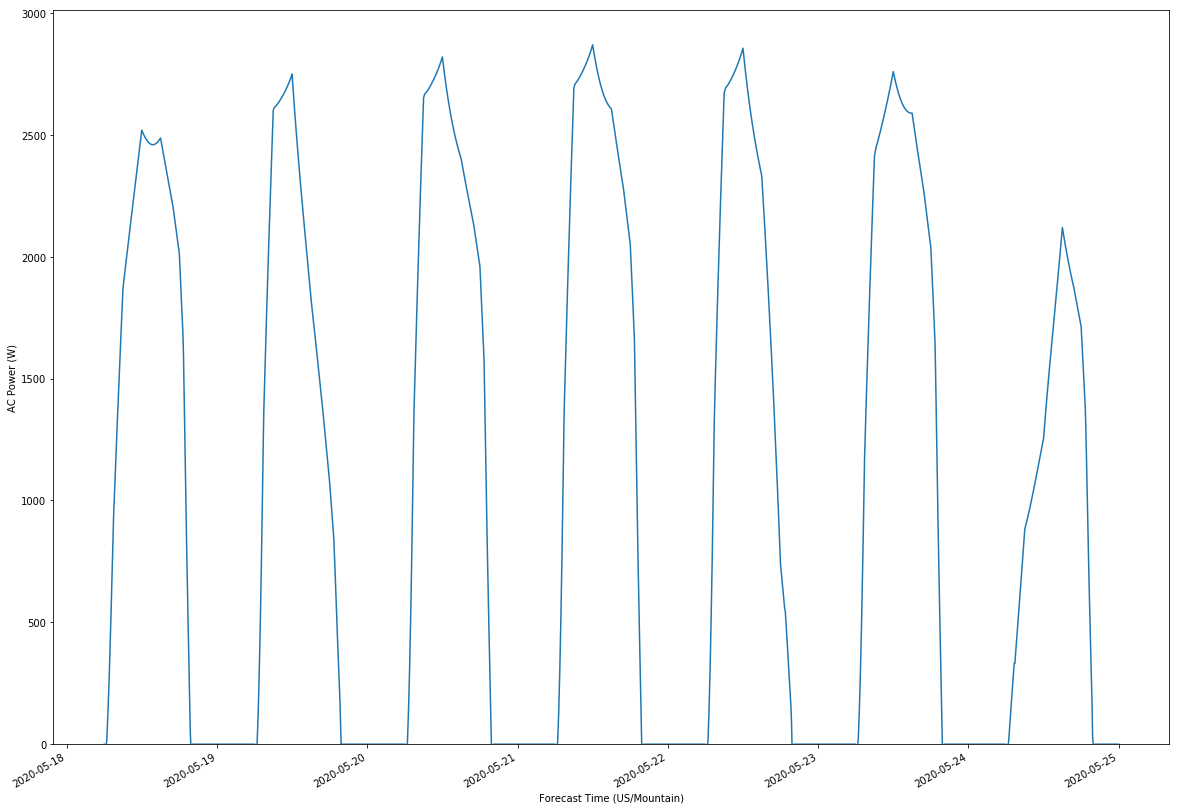

In [62]:
# AC Power
mc.ac.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('AC Power (W)');
plt.xlabel('Forecast Time ({})'.format(tz));

In [63]:
mc.ac.describe()

count    1185.000000
mean     1798.632277
std       880.616497
min        -1.560000
25%      1152.232403
50%      2073.817920
75%      2542.659771
max      2869.122379
dtype: float64

In [64]:
mc.ac.fillna(0)

2020-05-18 06:00:00-06:00       0.000000
2020-05-18 06:05:00-06:00      -1.560000
2020-05-18 06:10:00-06:00      -1.560000
2020-05-18 06:15:00-06:00      -1.560000
2020-05-18 06:20:00-06:00      -1.560000
2020-05-18 06:25:00-06:00      13.664137
2020-05-18 06:30:00-06:00      64.915980
2020-05-18 06:35:00-06:00     117.203693
2020-05-18 06:40:00-06:00     173.362426
2020-05-18 06:45:00-06:00     234.313834
2020-05-18 06:50:00-06:00     300.126752
2020-05-18 06:55:00-06:00     370.572680
2020-05-18 07:00:00-06:00     445.376884
2020-05-18 07:05:00-06:00     524.297351
2020-05-18 07:10:00-06:00     607.074041
2020-05-18 07:15:00-06:00     693.216429
2020-05-18 07:20:00-06:00     781.452277
2020-05-18 07:25:00-06:00     867.930706
2020-05-18 07:30:00-06:00     930.744044
2020-05-18 07:35:00-06:00     986.915385
2020-05-18 07:40:00-06:00    1042.552512
2020-05-18 07:45:00-06:00    1097.656590
2020-05-18 07:50:00-06:00    1152.232403
2020-05-18 07:55:00-06:00    1206.287741
2020-05-18 08:00

# Stop Running!

In [65]:
resampled_irrads

,ghi,dni,dhi
2020-05-18 06:00:00-06:00,0.000000,0.000000,0.000000
2020-05-18 06:05:00-06:00,0.078719,0.000000,0.078719
2020-05-18 06:10:00-06:00,0.572488,0.000000,0.572488
2020-05-18 06:15:00-06:00,1.915673,0.000000,1.915673
2020-05-18 06:20:00-06:00,4.421121,0.000000,4.421121
2020-05-18 06:25:00-06:00,8.187057,0.000000,8.187057
2020-05-18 06:30:00-06:00,13.167989,0.000000,13.167989
2020-05-18 06:35:00-06:00,19.258143,0.000000,19.258143
2020-05-18 06:40:00-06:00,26.340356,0.000000,26.340356
2020-05-18 06:45:00-06:00,34.307050,0.000000,34.307050


In [66]:
resampled_irrads.to_csv('Working Irrad.csv', encoding='utf-8')

In [67]:
mc.dc.fillna(0).to_csv('Working DC.csv', encoding='utf-8')

In [68]:
mc.ac.fillna(0).to_csv('Working AC.csv', encoding='utf-8')